# Ciencia de Datos (UdeSA) 2025 
## Clase 12 - Métodos de ensambles: Bootstrapping, Bagging & Random Forest

**Objetivo:** 
Que se familiaricen con los ensambles en la teoría y en la práctica con scikitlearn

### Temario:
- Bootstrapping: ilustración con la media muestral $\bar{X}$
- Ensemble Learning
- Bagging
- Random Forest


In [55]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from ISLP import load_data
import matplotlib.pyplot as plt

from sklearn import metrics 
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor 

### 1. Técnica de Remuestreo: Bootstrap

En **estadística**, dicho remuestreo con reposición genera que se cumpla el supuesto de *i.i.d.* para estimar un intervalo de confianza al nivel de significancia $\alpha$ y hacer test de hipótesis. Supongamos que tenemos una muestra de "n" valores (x) y nos gustaría obtener una estimación de la media de la muestra. Para hacerlo con *Bootstrapping* el procedimiento sería:

1. Crear muchas submuestras aleatorias (por ejemplo, 1000) del conjunto de datos con reemplazo (lo que significa que podemos seleccionar el mismo valor varias veces).
2. Calcular la media de cada submuestra. 
3. Calcular el promedio de todas nuestras medias recopiladas, y utilizar la fórmula de la varianza muestral para construir un intervalo de confianza.

En **Machine Learning**, el método *bootstrap* se refiere al muestreo aleatorio con reemplazo y se denomina *remuestreo*. La técnica permite que el modelo o algoritmo obtenga una mejor comprensión de los diversos sesgos, variaciones y características que existen en la muestra. Tomar una muestra de los datos permite que la nueva muestra contenga características diferentes de las que podría haber contenido en su totalidad. 


#### Ejercicio práctico con la base de Boston Housing 

En este ejemplo vamos a usar la base de datos de [Boston](https://islp.readthedocs.io/en/latest/datasets/Boston.html) con datos de casas.

**Variables in database:**
- CRIM:     per capita crime rate by town
- ZN:    proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS:   proportion of non-retail business acres per town
- CHAS:  Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX: nitric oxides concentration (parts per 10 million)
- RM: average number of rooms per dwelling
- AGE:      proportion of owner-occupied units built prior to 1940
- DIS:      weighted distances to five Boston employment centres
- RAD:      index of accessibility to radial highways
- TAX:      full-value property-tax rate per USD10,000
- PTRATIO:  pupil-teacher ratio by town
- LSTAT:    % lower status of the population
- MEDV:     Median value of owner-occupied homes in USD1000's

In [56]:
dataset = load_data('Boston')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


In [57]:
print(dataset.shape)
dataset.head() 

(506, 13)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [58]:
dataset.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
crim,506.0,3.61,8.60,0.01,0.08,0.26,3.68,88.98
zn,506.0,11.36,23.32,0.00,0.00,0.00,12.50,100.00
indus,506.0,11.14,6.86,0.46,5.19,9.69,18.10,27.74
chas,506.0,0.07,0.25,0.00,0.00,0.00,0.00,1.00
nox,506.0,0.55,0.12,0.38,0.45,0.54,0.62,0.87
rm,506.0,6.28,0.70,3.56,5.89,6.21,6.62,8.78
age,506.0,68.57,28.15,2.90,45.02,77.50,94.07,100.00
dis,506.0,3.80,2.11,1.13,2.10,3.21,5.19,12.13
rad,506.0,9.55,8.71,1.00,4.00,5.00,24.00,24.00
tax,506.0,408.24,168.54,187.00,279.00,330.00,666.00,711.00


In [59]:
# Vamos a predecir medv: median value of owner-occupied homes in $1000s.
y = dataset['medv']
print(y)
dataset['medv'].describe().round(2)

print("Para el total de la muestra la media es: ", round(y.mean(), 2), "\ny la desviación estandar es: ", round(np.std(y), 2))


0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: medv, Length: 506, dtype: float64
Para el total de la muestra la media es:  22.53 
y la desviación estandar es:  9.19


In [60]:
all_means = []
all_std = []

#Boostrapping de promedios y desvío estandard 
for sample in range(0,100): # B muestras bootstrappeadas
    boot = resample(y, replace = True, n_samples = 100) #tenemos 506 obs pero hacemos muestras de 100 (una submuestra<n)
    mean = boot.mean() # calculamos la media en la muestra b-émesima 
    std = np.std(boot) # calculamos el desvío standar en la muestra b-émesima 
    all_means.append(mean)
    all_std.append(std)


In [61]:
print("\nPara las submuestras la media es: ", round(np.mean(all_means), 2), "\n la desviación estandar de las medias es: ", round(np.std(all_means), 2), "\n\ny la desviación estandar bootstrappeada de la media muestral es: ", round(np.mean(all_std), 2))


Para las submuestras la media es:  22.55 
 la desviación estandar de las medias es:  1.1 

y la desviación estandar bootstrappeada de la media muestral es:  9.11


Alcanzamos una media muy similar pero una desviación estándar mucho menor.
Esta idea de Boostrap la vamos a usar en el ejemplo a continuación para predecir los precios de las viviendas.


### Motivación: ¿Por qué usar métodos de Ensamble?
Vimos el método de Árboles para clasificación o regresión, que se basaba en partir el espacio de atributos en 'rectángulos' o regiones.

Si bien este método tenía algunas ventajas como que es fácil de ilustrar y explicar, suele tener menos capacidad predictiva que otros métodos y suele ser poco robusto.

Entonces...

#### ¿Qué son los métodos de Ensamble?
Son métodos que tienen como objetivo mejorar el rendimiento predictivo de un modelo dado. El principio general de los métodos de ensamble es construir una combinación lineal de otros modelos, en lugar de utilizar un único modelo que por si solo tenga bajo poder predictivo (a estos se le llama *weak learners*). Por ejemplo, hay ensambles que combinan varios árboles de decisión para producir una mejor predicción que un solo árbol de decisión. El ensemble ayuda a reducir la varianza y/o el sesgo.

#### [Ensambles](https://scikit-learn.org/stable/modules/ensemble.html) 
El objetivo de los algoritmos de *ensemble* es combinar las predicciones de varios estimadores base construidos con un algoritmo de aprendizaje dado para mejorar la generalización / robustez sobre un solo estimador.

##### Hay dos familias de métodos de ensamble que generalmente se distinguen:

**Métodos de promedio:** el principio impulsor es construir varios estimadores de forma independiente y luego promediar sus predicciones. En promedio, el estimador combinado suele ser mejor que cualquiera de los estimadores de base única porque su varianza es menor y ayuda a evitar el sobreajuste. **Ejemplos:** *Bootstrap Aggregation (Bagging)*, *Random Forest*.

**Métodos de Boosting:** los estimadores base se construyen secuencialmente y se intenta reducir el sesgo del estimador combinado. Esto puede causar sobreajuste. Para evitarlo, el ajuste de parámetros juega un papel importante en la mejora de estos algoritmos. La motivación es combinar varios modelos débiles para producir un modelo más robusto. 
**Ejemplos:** *AdaBoost*, *Gradient Tree Boosting*, *GBM*, *XGBM*.

#### Ventajas del ensamble
- Los ensambles mejoran la precisión del modelo y funcionan en la mayoría de los casos.
- Los ensambles hacen que el modelo sea más robusto y estable, lo que garantiza un rendimiento decente en los casos de prueba en la mayoría de los escenarios.
- Los ensambles se pueden utilizar para capturar relaciones lineales, simples y complejas, así como no lineales en los datos. Esto se puede hacer usando dos modelos diferentes y formando un ensamble con ellos.

#### Desventajas del ensamble
- Los ensambles reducen la interpretabilidad del modelo y hacen que sea difícil comunicar los resultados.
- Llevan más tiempo y, por lo tanto, podría no ser la mejor idea para aplicaciones en tiempo real.
- La selección de modelos para crear un ensamble es un arte realmente difícil de dominar.

#### Técnicas básicas de ensambles
- *Majority Vote*: es una de las formas más simples de combinar predicciones de múltiples algoritmos de aprendizaje automático. Cada modelo base hace una predicción y vota para cada muestra. Para cada una de las observaciones, la clase con más votos se considera la clase predictiva final. Se utiliza principalmente para problemas de clasificación.
- *Promedio*: el promedio generalmente se usa para problemas de regresión (pero se puede utilizar al estimar las probabilidades en las tareas de clasificación). Las predicciones se extraen de varios modelos y se utiliza un promedio de las predicciones para hacer la predicción final.
- *Promedio ponderado*: al igual que el promedio, el promedio ponderado también se usa para tareas de regresión. Alternativamente, se puede utilizar al estimar probabilidades en problemas de clasificación. A los modelos de base se les asignan diferentes ponderaciones, que representan la importancia de cada modelo en la predicción.


### Preparación de datos para entrenamiento

En primer lugar, dividiremos los datos en conjuntos de "atributos" (X) y "etiquetas" (y). El resultado luego se dividirá en conjuntos de entrenamiento y prueba.

En segundo lugar, notarán que los valores de la base de datos no están muy bien escalados. El campo TAX tiene valores en el rango de las centenas, mientras que RAD por ejemplo tiene valores en el rango de unidades. Será mejor si escalamos los datos. Usaremos la clase StandardScaler de Scikit-Learn para hacerlo.

In [62]:
# Definimos la Matriz `X` y vector `y` a predecir
X = dataset.iloc[:, 0:12]
y = dataset.iloc[:, 12].values
X.head()


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33


In [63]:
X.shape

(506, 12)

In [64]:
# Enfoque de validacion
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [65]:
# Escalamos los predictores
sc = StandardScaler() 
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)

In [66]:
# Chequeamos la transformación de nuestros predictores en entrenamiento y testeo
print("X_train:")
print("Media:", X_train.mean(axis=0).round(2))
print("Desviación estándar:", X_train.std(axis=0).round(2))
print("Obs x cols:", X_train.shape)

print("\nX_test:")
print("Media:", X_test.mean(axis=0).round(2))
print("Desviación estándar:", X_test.std(axis=0).round(2))
print("Obs x cols:", X_test.shape)

X_train:
Media: [-0.  0. -0.  0. -0.  0. -0. -0. -0.  0.  0.  0.]
Desviación estándar: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Obs x cols: (404, 12)

X_test:
Media: [ 0.14 -0.09  0.01 -0.   -0.05 -0.12 -0.08  0.06  0.08  0.16 -0.02 -0.04]
Desviación estándar: [1.25 0.93 0.9  1.   1.03 1.05 1.01 1.06 1.02 0.92 0.93 0.89]
Obs x cols: (102, 12)


### 0. CART: repaso!
Para utilizar Arboles de regresión y clasificación con Scikit-Learn tenemos [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) y [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreeclassifier#sklearn.tree.DecisionTreeClassifier). En este caso usaremos DecisionTreeRegressor dado que queremos predecir el valor de las viviendas.

In [67]:
cv = KFold(n_splits=10, shuffle = True, random_state = 10)            
mses = list()
max_attributes = X_train.shape[1]
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_mse = []
    tree_model = DecisionTreeRegressor(max_depth = depth, random_state = 10) # Aqui ajusta los hiperparametros a la grilla 
    
    for train_index, valida_index in cv.split(X_train):   
        x_train, x_valida = X_train[train_index], X_train[valida_index] 
        y_train, y_valida = Y_train[train_index], Y_train[valida_index] 
    
        model = tree_model.fit(x_train, y_train) # estima el modelo en el fold k-ésimo
        y_pred = model.predict(x_valida)
        mse = mean_squared_error(y_pred, y_valida)
        fold_mse.append(mse)
        
    avg = sum(fold_mse)/len(fold_mse)
    mses.append(avg)
    
df = pd.DataFrame({"Max Depth": depth_range, "Average MSE": mses})
df = df[["Max Depth", "Average MSE"]].round(2)
print(df.to_string(index=False))


 Max Depth  Average MSE
         1        54.55
         2        29.36
         3        19.69
         4        16.00
         5        16.36
         6        14.70
         7        16.87
         8        12.95
         9        14.54
        10        14.28
        11        15.69
        12        13.43


In [68]:
# Loop para seleccionar max_depth por cross-validation
min_mse = np.inf
depth = None
for index, row in df.iterrows():
    if row['Average MSE'] < min_mse:
        min_mse = row['Average MSE']
        depth_cv = row['Max Depth']
print('El mínimo error es', round(min_mse, 2), 'y se da con nivel de profundidad', depth_cv)


El mínimo error es 12.95 y se da con nivel de profundidad 8.0


In [69]:
# Arbol de regresion con profundidad elegida por CV
tree_model_cv = DecisionTreeRegressor(max_depth = 8)
tree_model_cv.fit(X_train, Y_train) 
y_pred = tree_model.predict(X_test)

In [70]:
from sklearn.tree import  plot_tree

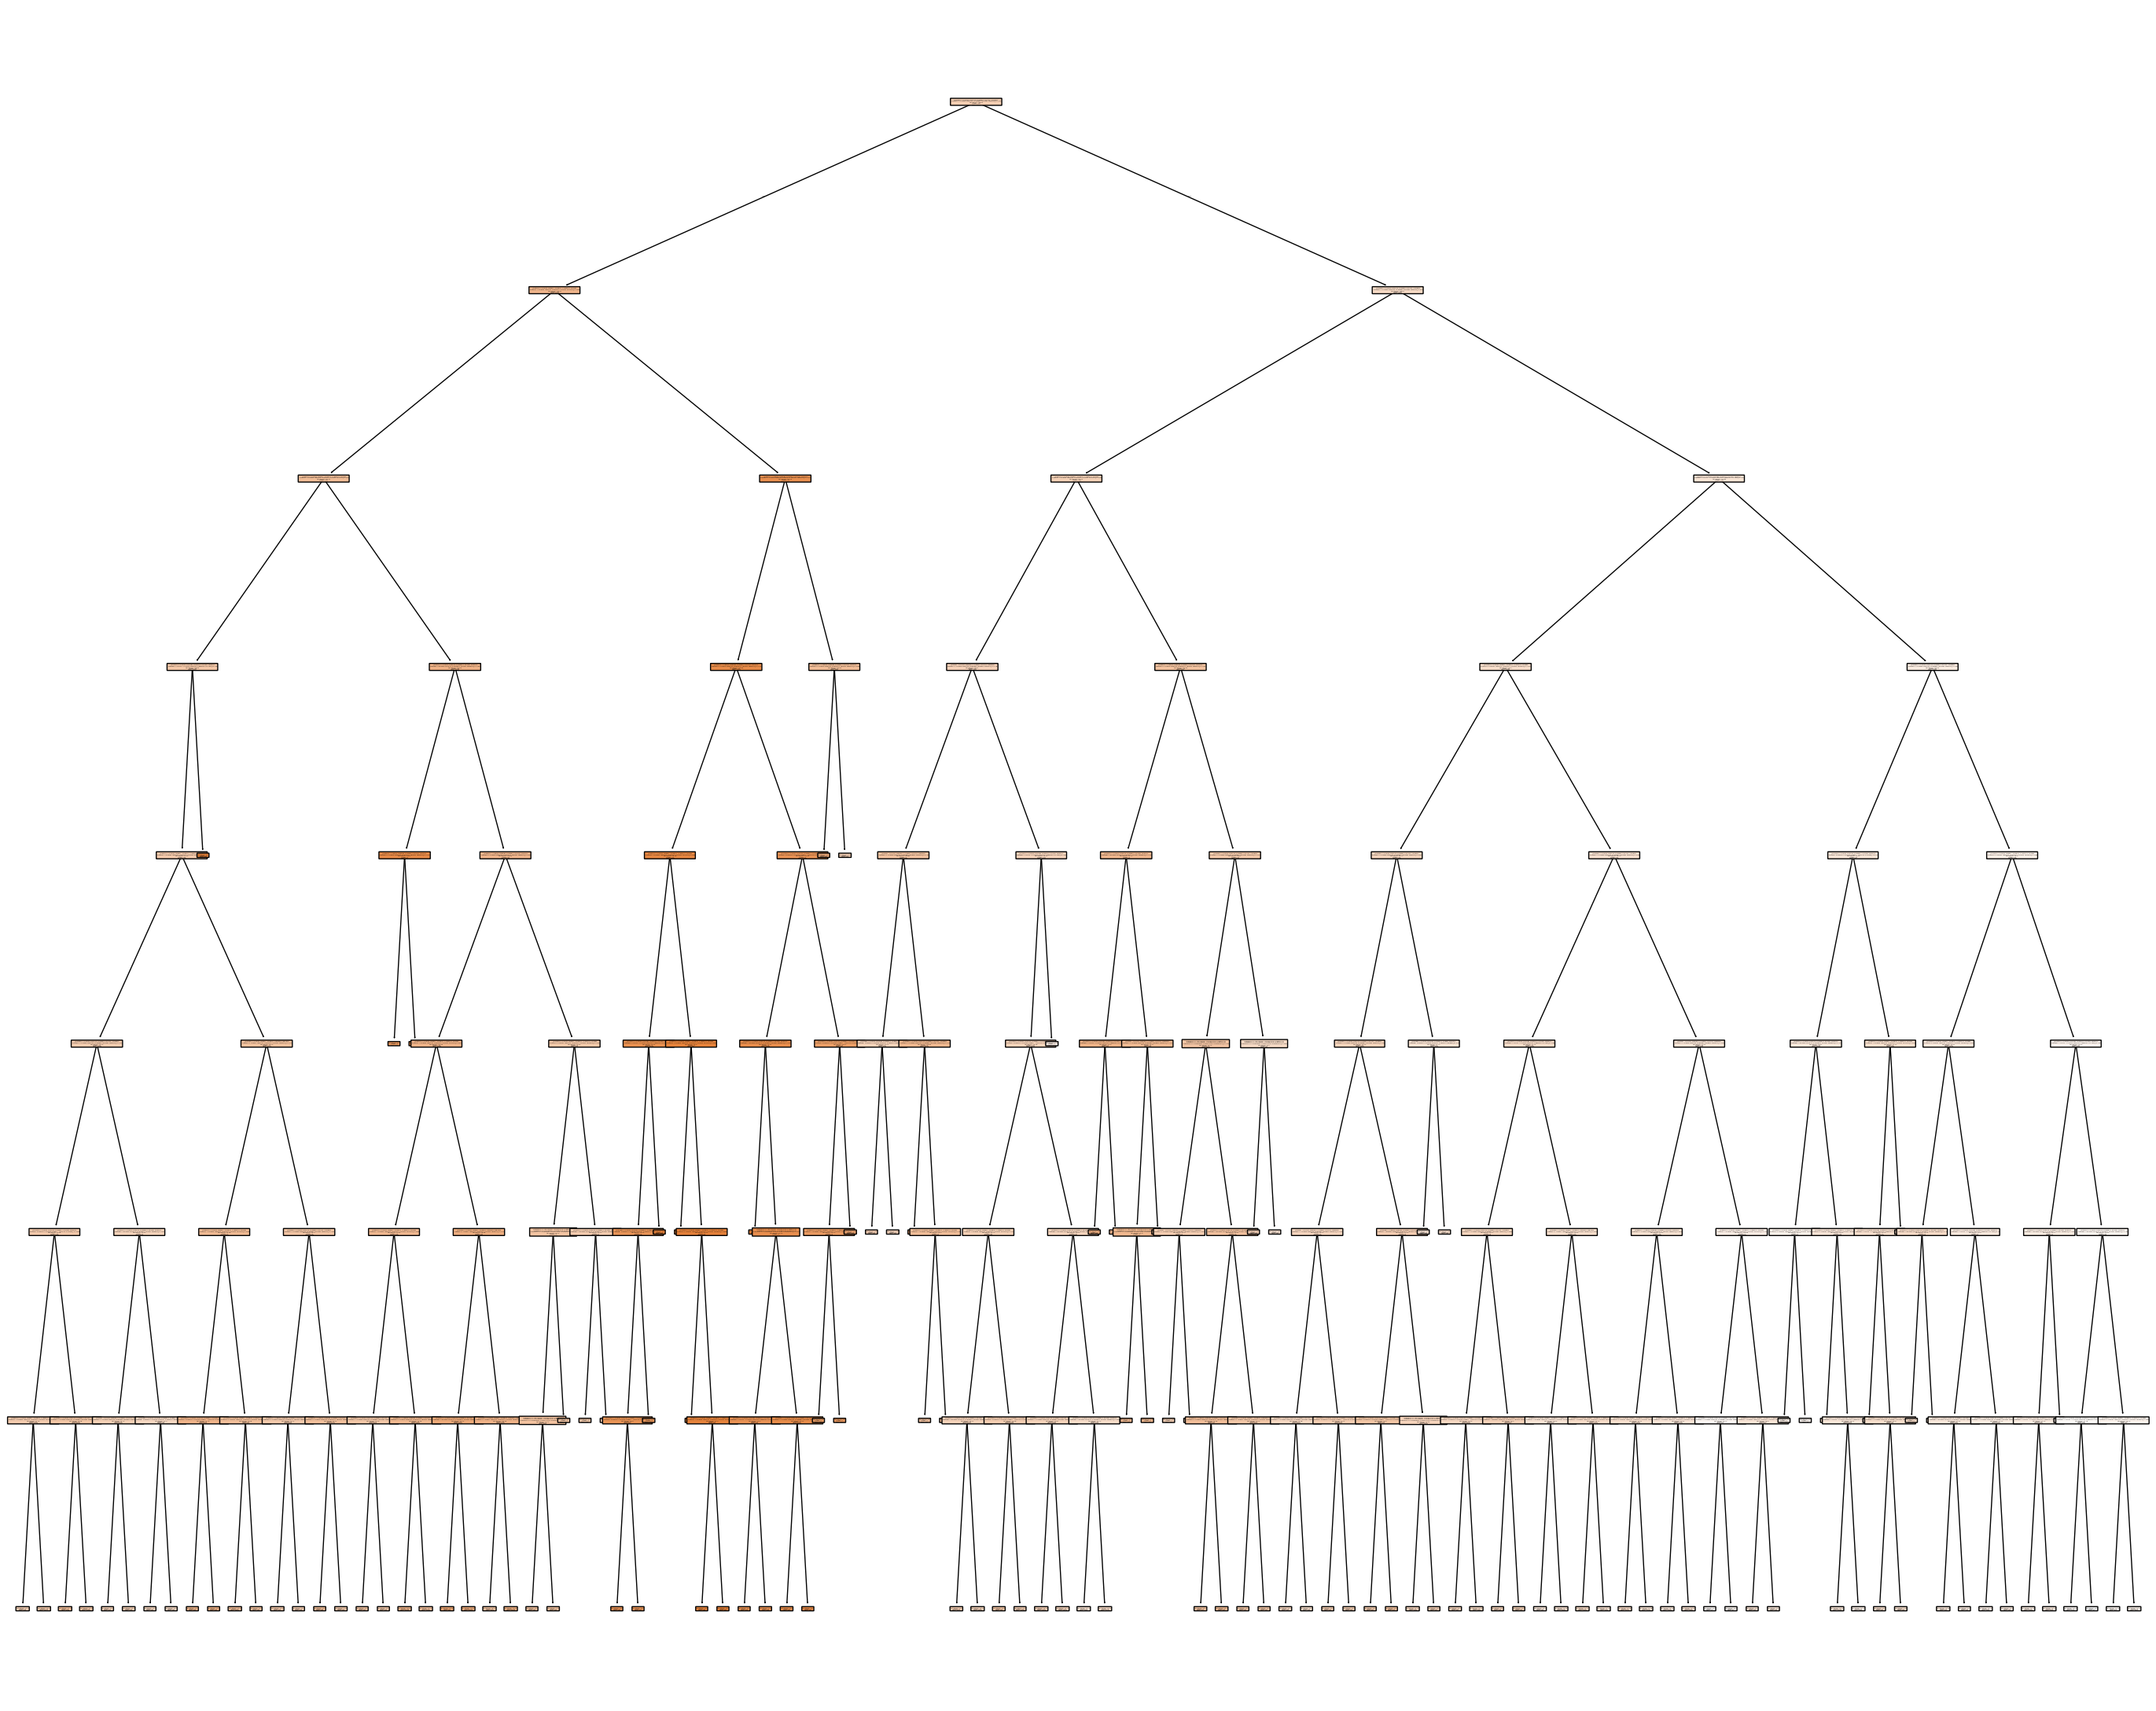

In [29]:
# Gráfico
fig = plt.figure(figsize=(35,28))
graph = plot_tree(tree_model_cv,
                  feature_names = list(X_train),
                  rounded = True, 
                  filled = True   #colorear los nodos p/ indicar la clase mayoritaria (p/ clasif.)
                 )

In [71]:
tree_model = DecisionTreeRegressor()
depth_range = range(1, max_attributes + 1)
tree_para = {'max_depth':depth_range}
grid_search = GridSearchCV(tree_model, tree_para, cv=10, scoring='neg_median_absolute_error')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 13)},
             scoring='neg_median_absolute_error')

In [72]:
# Extraemos el mejor modelo
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_test)
print(best_tree)

DecisionTreeRegressor(max_depth=9)


#### Evaluación del algoritmo
Evaluemos el desempeño del algoritmo observando el error cuadrático medio.

In [73]:
mse_cart = metrics.mean_squared_error(Y_test, y_pred)
print('MSE test:', round(mse_cart, 2)) 

MSE test: 36.17


#### Importancia de las variables en la predicción de CART

Un atributo de los arboles de decision es el calculo de la *importancia relativa de las variables*. Intuitivamente, se mide el nivel de impureza en cada nodo (en regresion con MSE, en clasificacion con Gini, como vimos en la clase anterior), y se compara **entre predictores** quién logra una mayor caída del nivel de impureza dentro del nodo (osea que las observaciones son mas parecidad en caracteristica y por lo tanto nuestro error de predicción menor).

Formalmente, la importancia de una característica se calcula como:
1. Para cada nodo $i$ en el árbol, calcula la reducción de la impureza $\Delta i$ cuando se divide el nodo utilizando el predictor $j$
2. Calcula la proporción de muestras $w_i$ que llegan al nodo $i$
3. La importancia del predictor $j$ se calcula como

$$
FeatureImportances_j= \frac{\Sigma (\Delta i \times w_i)}{\Sigma (\Delta i \times w_i)\text{sobre todos los nodos i}}
$$


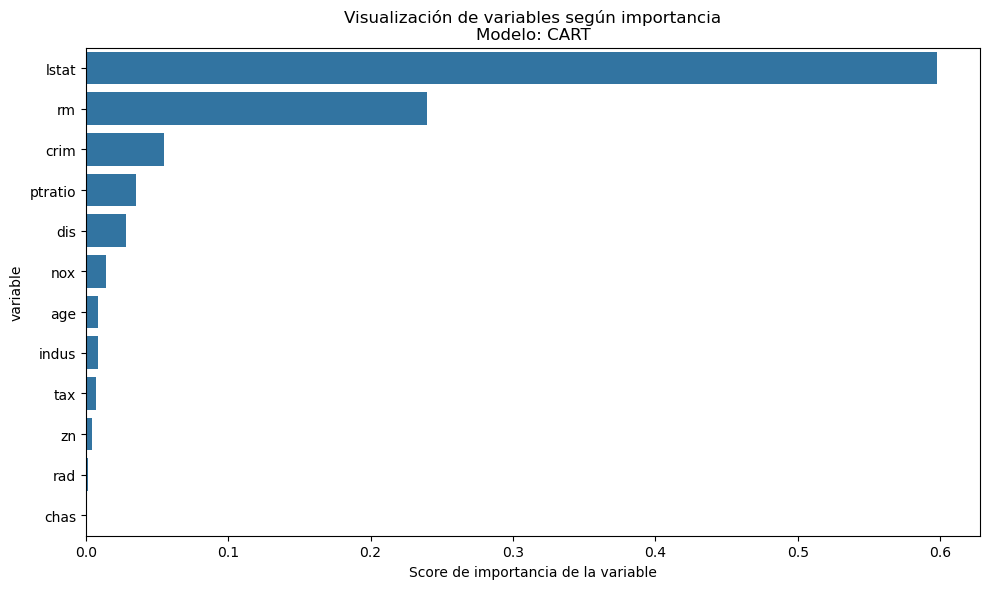

In [74]:
feature_imp = pd.Series(best_tree.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Score de importancia de la variable')
plt.ylabel('variable')
plt.title("Visualización de variables según importancia\nModelo: CART")
plt.tight_layout()

## 1. Bagging (Bootstrap Aggregation)
Es un poderoso método de ensamble para evitar el sobreajuste. El concepto detrás del *bagging* es combinar las predicciones de varios modelos básicos para crear un resultado más preciso. *Bagging* es la aplicación del procedimiento Bootstrap a un algoritmo de aprendizaje automático de alta varianza, por ejemplo, los árboles de decisión. El rendimiento de los algoritmos de aprendizaje automático de alta varianza, como los árboles de decisión sin podar, se puede mejorar entrenando muchos árboles y tomando el promedio de sus predicciones. Los resultados suelen ser mejores que un solo árbol de decisiones.

Procedimiento:

0. Suponiendo que hay N observaciones y p características 
1. Se seleccionan B muestras de las observaciones al azar con reemplazo (Bootstrapping).
2. Se entrena el modelo en cada uno de los B datasets. 
3. Finalmente, la predicción se basa en la **agregación** de predicciones de todos los modelos (votación para los clasificadores o el promedio para las regresiones). Cada hipótesis tiene el mismo peso que todas las demás. 


Para utilizar Bagging con Scikit-Learn tenemos [BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor) y [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier). En este caso usaremos BaggingRegressor dado que queremos predecir el valor de las viviendas (variable continua).

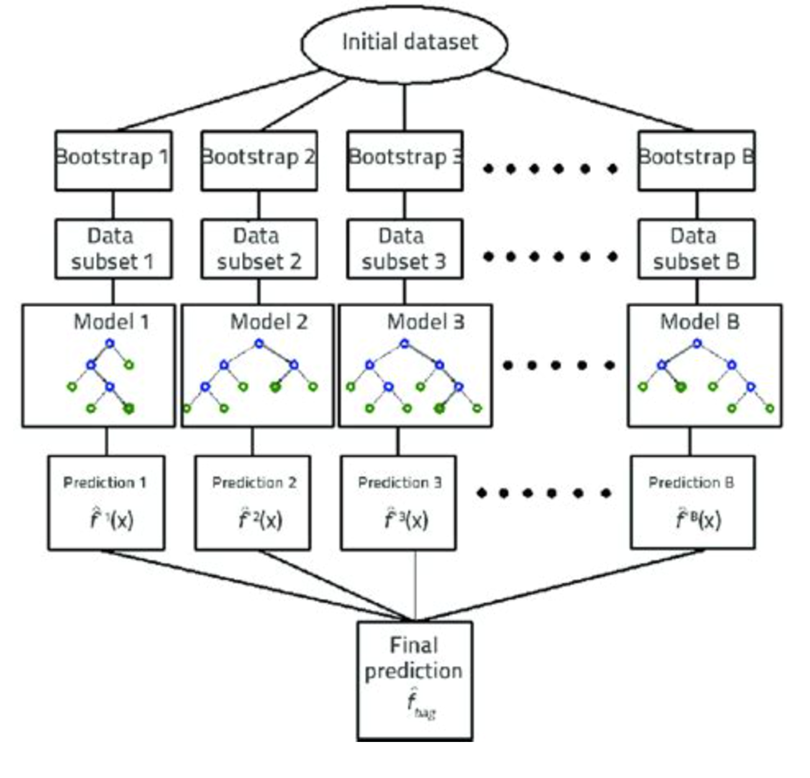

In [75]:
regressor = BaggingRegressor(n_estimators=25, max_samples=200, random_state=1) 
# n_estimators (Es None por default, y cuando eso ocurre el estimador es DecisionTreeRegressor.)
# n_estimators: cuántos modelos se corren/ cuantas muestras boostrappeadas
# max_samples: cuántas observaciones se consideran para cada modelo
# bootstrap: Si las muestras se obtienen con reemplazo (por default es True)
regressor.fit(X_train, Y_train) 
y_predB = regressor.predict(X_test)

In [76]:
mse_bagg = metrics.mean_squared_error(Y_test, y_predB)
print('MSE test (B=25):', round(mse_bagg, 2)) 

MSE test (B=25): 21.33


##### Probamos con distintas muestras boostrappeadas `n_estimators`

In [77]:
regressor2 = BaggingRegressor(n_estimators=100, max_samples=200, random_state=1) 

regressor2.fit(X_train, Y_train) 
y_predB2 = regressor2.predict(X_test)

In [78]:
mse_bagg2 = metrics.mean_squared_error(Y_test, y_predB2)
print('MSE test (B=100):', round(mse_bagg2, 2)) 

MSE test (B=100): 22.32


In [79]:
regressor3 = BaggingRegressor(n_estimators=10, max_samples=200, random_state=1) 

regressor3.fit(X_train, Y_train) 
y_predB3 = regressor3.predict(X_test)

mse_bagg3 = metrics.mean_squared_error(Y_test, y_predB3)


In [80]:
print('MSE test (CART, B=1):', round(mse_cart, 2)) 
print('MSE test (B=10):', round(mse_bagg3,2)) 
print('MSE test (B=25):', round(mse_bagg, 2)) 
print('MSE test (B=100):', round(mse_bagg2, 2)) 

MSE test (CART, B=1): 36.17
MSE test (B=10): 27.48
MSE test (B=25): 21.33
MSE test (B=100): 22.32


#### Encontramos el parametro de tunning por Cross-Validation


In [81]:
# Set simple de Bagging
bagg_model = BaggingRegressor(max_samples=200, random_state=1) 
# Cantidad de muestras boostrapeadas (y por lo tanto arboles estimados que se promedian)
Bsamples = [1, 5, 10, 25, 100, 200, 500]
bagg_para = {'n_estimators':Bsamples}

# Estimacion para la grilla de parametro de tunning
grid_search = GridSearchCV(bagg_model, bagg_para, cv=10, scoring='neg_median_absolute_error')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=BaggingRegressor(max_samples=200, random_state=1),
             param_grid={'n_estimators': [1, 5, 10, 25, 100, 200, 500]},
             scoring='neg_median_absolute_error')

In [83]:
# Extraemos el mejor modelo
best_bagg = grid_search.best_estimator_
y_pred = best_bagg.predict(X_test)
best_bagg

BaggingRegressor(max_samples=200, n_estimators=200, random_state=1)

#### Evaluación de Bagging con `B` elegido por cross-validation

In [85]:
mse_bagg = metrics.mean_squared_error(Y_test, y_pred)
print('MSE test:', round(mse_bagg, 2)) 

MSE test: 22.6


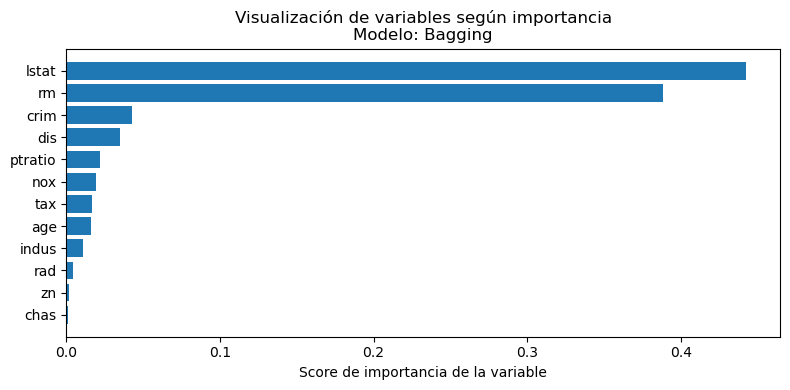

In [86]:
# Importancia promedio de los árboles del Bagging
importances = np.mean(
    [est.feature_importances_ for est in best_bagg.estimators_],
    axis=0
)

# Nombres originales de las variables explicativas
feature_names = dataset.drop(columns=['medv']).columns   # cambia 'medv' si tu Y se llama distinto

# Serie ordenada para graficar
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(feat_imp.index, feat_imp.values)
plt.xlabel('Score de importancia de la variable')
plt.title('Visualización de variables según importancia\nModelo: Bagging')
plt.tight_layout()
plt.show()

In [87]:
best_B = 200 # el B que elegiste por CV

max_depth_list = [None, 25, 20, 15, 10, 5, 3, 2]

for md in max_depth_list:
    base_tree = DecisionTreeRegressor(max_depth=md, random_state=1)
    bagg = BaggingRegressor(
        estimator=base_tree,   
        n_estimators=best_B,        
        max_samples=200,
        random_state=1
    )
    bagg.fit(X_train, Y_train)
    y_pred = bagg.predict(X_test)
    mse = mean_squared_error(Y_test, y_pred)
    print(f"max_depth={md}, MSE test={mse:.2f}")

max_depth=None, MSE test=22.60
max_depth=25, MSE test=22.60
max_depth=20, MSE test=22.61
max_depth=15, MSE test=22.61
max_depth=10, MSE test=22.75
max_depth=5, MSE test=23.24
max_depth=3, MSE test=24.16
max_depth=2, MSE test=28.62


## 2. Random Forest Regressor
El Random Forest, como Bagging, construye árboles de decisión con muestras obtenidas por bootstrapping y promedia los resultados de cada árbol para obtener la predicción final. 
Por qué "random"?
 - Muestreo aleatorio de datos de entrenamiento al construir árboles
 - Al dividir nodos, considera subconjuntos aleatorios de características para hacer la división (en lugar todos los predictores disponibles).
 
Así, los árboles obtenidos en el proceso estarán menos correlacionados y al promediarlos, la reducción en la varianza será mayor que la que se obtendría al promediar árboles más correlacionados.

Para utilizar Random Forest con Scikit-Learn tenemos [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=randomforestregressor#sklearn.ensemble.RandomForestRegressor) y [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier). En este caso usaremos RandomForestRegressor dado que queremos predecir el valor de las viviendas. 

In [88]:
regressor = RandomForestRegressor(n_estimators=200, max_samples=200, max_features=1, random_state=1) 
# max_features: es el subconjunto de predictores m (en slides) a considerar. El default es  max_features=1
regressor.fit(X_train, Y_train) 
y_pred = regressor.predict(X_test)
mse_test_rf1 = metrics.mean_squared_error(Y_test, y_pred)
print('MSE testeo (m=1):', round(mse_test_rf1, 2))

MSE testeo (m=1): 32.72


##### Probamos con distinto numero de predictores disponibles `max_features` 
($m$ en las slides de clase)

In [89]:
regressor2 = RandomForestRegressor(n_estimators=200, max_samples=200, max_features=5, random_state=1) 


regressor2.fit(X_train, Y_train) 
y_pred2 = regressor2.predict(X_test)
mse_test_rf2 = metrics.mean_squared_error(Y_test, y_pred2)
print('MSE testeo (m=5):', round(mse_test_rf2, 2))

MSE testeo (m=5): 26.9


Recordemos que en caso de regresion, el *numero sugerido* es $m=\sqrt{p}$ con $p$ numero de predictores

In [90]:
import math

num_columnas = X_train.shape[1]
m_sugerido = math.sqrt(num_columnas)
print(round(m_sugerido,0))

3.0


In [91]:
regressor3 = RandomForestRegressor(n_estimators=200, max_samples=200, max_features=3, random_state=1) 


regressor3.fit(X_train, Y_train) 
y_pred3 = regressor3.predict(X_test)
mse_test_rf3 = metrics.mean_squared_error(Y_test, y_pred3)


In [92]:
print('MSE testeo (m=1):', round(mse_test_rf1, 2))
print('MSE testeo (m=3, sugerido):', round(mse_test_rf3, 2))
print('MSE testeo (m=5):', round(mse_test_rf2, 2))

MSE testeo (m=1): 32.72
MSE testeo (m=3, sugerido): 28.13
MSE testeo (m=5): 26.9


#### Encontramos el parametro de tunning por Cross-Validation¶

In [93]:
# Set simple de Ranfom Forest
rf_model = RandomForestRegressor(max_samples=300, random_state=1) 

# Cantidad de predictures posibles a usar 
max_attributes = X_train.shape[1]
m_range = range(1, max_attributes + 1)
rf_para = {'max_features':m_range}

# Estimacion para la grilla de parametro de tunning
grid_search = GridSearchCV(rf_model, rf_para, cv=10, scoring='neg_median_absolute_error')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=10,
             estimator=RandomForestRegressor(max_samples=300, random_state=1),
             param_grid={'max_features': range(1, 13)},
             scoring='neg_median_absolute_error')

In [51]:
# Extraemos el mejor modelo
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
best_rf

RandomForestRegressor(max_features=10, max_samples=300, random_state=1)

#### Evaluacion de Random Forest con $m$ features elegido por cross-validation

In [52]:
mse_rf = metrics.mean_squared_error(Y_test, y_pred_rf)
print('MSE test:', round(mse_rf, 2)) 

MSE test: 22.16


#### Importancia relativa para Random Forest

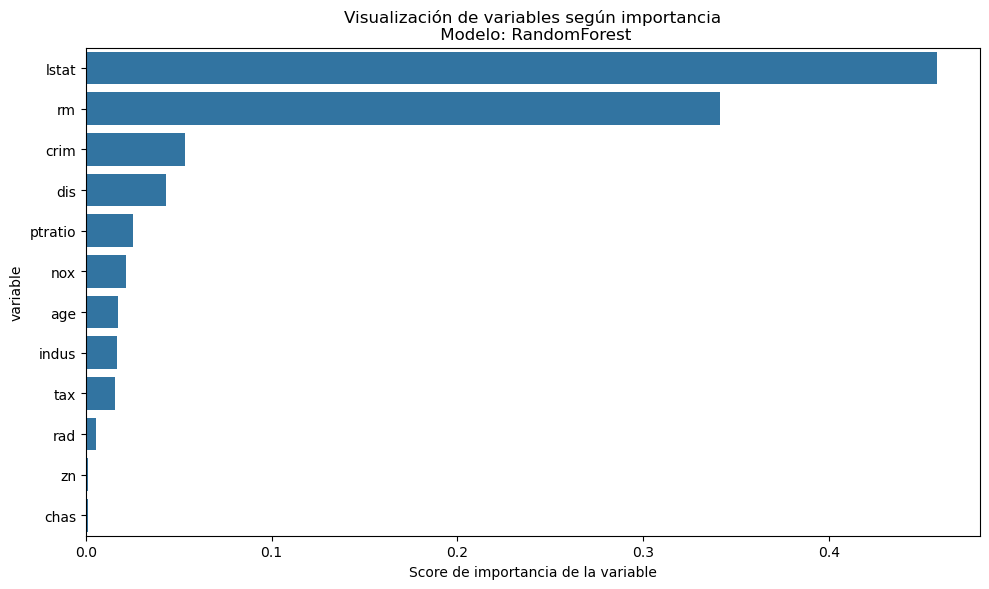

In [53]:
feature_imprf = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imprf, y=feature_imprf.index)
plt.xlabel('Score de importancia de la variable')
plt.ylabel('variable')
plt.title("Visualización de variables según importancia\n Modelo: RandomForest")
plt.tight_layout()

### Comparacion final entre modelos

In [94]:
print('MSE test CART:', round(mse_cart, 2)) 
print('MSE test Bagging:', round(mse_bagg, 2)) 
print('MSE test Random Forest:', round(mse_rf, 2)) 

MSE test CART: 36.17
MSE test Bagging: 22.6
MSE test Random Forest: 22.16


#### RF no garantiza siempre menor error que Bagging. Si las variables importantes son pocas y muy fuertes, y la varianza del modelo no es tan grande, forzar más aleatoriedad (RF) puede subir el sesgo más de lo que baja la varianza, y Bagging termina ganando en MSE.
